In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit
from scipy.optimize import brentq
from statsmodels.tsa.stattools import acf

In [5]:
#parameters

mu = 0.34
eta = 0.01
beta = 0.99 #change to 0.99 for final
theta = 0.36
delta = 0.025
rho = 0.9
sigma = 2
nz = 5
nk = 100
tol=1e-10,
maxit=10000

In [6]:
#this is the hw2_ex_v3 code from Rajesh--edit to fit our needs

class Ramsey_Econ602:

    def __init__(self,
                 mu,
                 sigma,
                 beta,
                 theta,
                 delta,
                 rho,
                 eta,
                 nk=100,
                 nz=5,
                 tol=1e-10,
                 maxit=10000):
        
        self.mu = mu
        self.sigma = sigma
        self.beta = beta
        self.theta = theta
        self.delta = delta
        self.rho = rho
        self.eta = eta
        self.nk = nk
        self.nz = nz
        
        # get the state values and transition matrix from the markov chain for z
        self.markov_chain = qe.markov.tauchen(rho, eta, 0, 3, nz)
        self.z_state_values = self.markov_chain.state_values #the formula we're given is ln(z) = rho*ln(z_{-1}) + epsilon_i
        self.transition_matrix = self.markov_chain.P
                                
        #steady state k and l (capital and leisure)
        #these are just to approximate bounds for a linear space that we'll iterate over
        self.ls = (1-theta)/(((1-mu)/mu)+1-theta-((1-mu)/mu)*((delta*theta)/(1/beta-(1-delta))))
        self.ks = self.ls*((1/beta-(1-delta))/theta)**(1/(theta-1))
        
        #need self.kgrid and zgrid because k and z are our state variables
        self.kgrid = np.linspace(0.8*self.ks, 1.2*self.ks, nk)
        self.zgrid = np.exp(self.z_state_values)

        # Allocate memory--essentially we're just pre-defining the shape of objects we'll pass into functions to fill later
        self.v = np.zeros((nz,nk)) #initial guess for Bellman is zeros
        self.gk_index = np.empty((nz,nk))
        self.gpr = np.empty((nz,nk))
        self.Ret = np.zeros((nz,nk,nk))
        l = np.empty((nz,nk,nk))
        
        #here's where we need to solve for leisure
        
        for z_i in range(nz):
            for k_i in range(nk):
                for k_prime_i in range(nk):
                    kz = (self.kgrid[k_prime_i]-(1-delta)*self.kgrid[k_i])/(self.zgrid[z_i]*(self.kgrid[k_i])**theta)
                    if kz >= 1:
                        l[z_i,k_i,k_prime_i] = 1
                    else:
                        l[z_i,k_i,k_prime_i] = brentq(lambda x: (x**(1-theta))*((1-mu)/mu + 1-theta - (1-theta)/x) - ((1-mu)/mu)*kz,0.0000000001,1)
    
        self.l = l
        
        # compute the return function
        _compute_returns(self.kgrid,self.zgrid,self.delta,self.theta,self.mu,self.sigma,self.l,self.Ret)
                
        # Compute the value function and policy function
        self.solve(tol=tol, maxit=maxit)
        self.kpr_policy()
        self.endog_dist()
        self.inv_gdp()
   
    # solve is the actual value function iteration
    def solve(self, tol=1e-9, maxit=10000):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Allocate memory to store next iterate of value function
        v_upd = np.zeros((self.nz,self.nk))
        
        # Main loop
        while dist > tol and maxit > it:
            
            self.E_v = np.matmul(self.transition_matrix, self.v)
            
            _inner_loop(self.Ret,self.v,self.E_v,self.beta,self.zgrid,self.kgrid)
            
            dist = np.max(np.abs(v_upd - self.v))
            v_upd[:] = self.v[:]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")

        return None    
        
    # This is to recover policy function after the value function has converged
    
    def kpr_policy(self):
    
    # Compute gpr and its index: best index in kgrid given ik  
        self.gpr = np.empty((self.nz,self.nk))
        self.kgpr = np.empty((self.nz,self.nk))
        self.lk = np.empty((self.nz,self.nk))
        self.labor = np.empty((self.nz,self.nk))
        self.cons = np.empty((self.nz,self.nk))

        self.gpr, self.kgpr, self.lk, self.labor, self.cons = _compute_savings_policy(self.kgrid, 
                                                                                        self.zgrid, 
                                                                                        self.Ret, 
                                                                                        self.v, 
                                                                                        self.E_v, 
                                                                                        self.beta, 
                                                                                        self.gpr, 
                                                                                        self.kgpr, 
                                                                                        self.lk, 
                                                                                        self.labor, 
                                                                                        self.cons, 
                                                                                        self.l,
                                                                                        self.delta,
                                                                                        self.theta
                                                                                       )
        
        #print(self.kgpr)
        
    def endog_dist(self):
        self.g = np.zeros((self.nz*self.nk,self.nz*self.nk))
        self.prob = (1/(self.nz*self.nk))*np.ones((self.nz*self.nk))
        self.dist = np.zeros((self.nk))
               
        #_state_t1 finds the state transition matrix g
        self.g = _state_t1(self.transition_matrix,self.kgpr,self.g)
        #print(self.g)
        
        #this loop should iterate over probabilities until they converge, but it's static. 
        #how do we change probabilities toward convergence? 
        test = 1
        while test > 10**(-10):
            prob1 = self.prob @ self.g
            test = np.max(np.abs(prob1 - self.prob))
            self.prob = prob1
        
        #_state_t2 finds the distribution for capital
        _state_t2(self.nz,self.nk,self.prob,self.dist)
        
        return self.g,self.prob,self.dist
    
    def inv_gdp(self):
    
    # Compute i and y
    
        self.inv = self.gpr - (1-self.delta)*np.tile(self.kgrid,(self.nz,1)) 
        self.gdp = np.vstack(self.zgrid)*(((np.tile(self.kgrid,(self.nz,1)))**self.theta)*(self.labor**(1-self.theta)))
        
        return self.inv,self.gdp

# Just to compute utility--need to solve for leisure before this can work        
@jit(nopython=True)
def u(c, l, mu, sigma):
    return (1/(1-sigma))*((c**mu)*((1-l)**(1-mu)))**(1-sigma)

#we need to get the expected value of the bellman by multiplying v(z',k') with the corresponding value in the transition matrix
@jit(nopython=True)
def _inner_loop(Ret,v,E_v,beta,zgrid,kgrid):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                # m is the Bellman: Ret is utility, and E_v is expected bellman
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]

                if m > current_max:
                    current_max = m      

            v[z_i,k_i] = current_max  
            
    return None

#this will have an nz loop added too
#need the expected value of the Bellman here too
#@jit(nopython=True)
def _compute_savings_policy(kgrid,zgrid,Ret,v,E_v,beta,gpr,kgpr,lk,labor,cons,l,delta,theta):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]
                if m > current_max:
                    current_max = m
                    current_max_index = k_prime_i
            gpr[z_i,k_i] = kgrid[current_max_index]
            kgpr[z_i,k_i] = current_max_index
            lk = l[z_i,k_i,current_max_index]
            labor[z_i,k_i] = lk
            #print(f"gpr: {gpr}")
            #print(f"kgpr: {kgpr}")
            #print(f"lk: {lk}")
            #print(f"zgrid: {zgrid[z_i]}")
            #print(f"kgrid: {kgrid[k_i]**theta}")
            #print(f"labor: {labor**(1-theta)}")
            #print(f"kgrid_prime: {kgrid[current_max_index]}")
            cons[z_i,k_i] = zgrid[z_i]*(kgrid[k_i]**theta)*(lk**(1-theta))+(1-delta)*kgrid[k_i]-kgrid[current_max_index]
            
    #print(kgpr and everything else)
    return gpr, kgpr, lk, labor, cons
            #add kgpr, consumption, investment, labor, etc--it can all happen here

#this will have an nz loop added too
@jit(nopython=True)
def _compute_returns(kgrid,zgrid,delta,theta,mu,sigma,l,Ret):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            for k_prime_i in range(len(kgrid)):
                #l_i is just the number corresponding to the z_i, k_i, k_prime_i position in the l matrix
                l_i = l[z_i,k_i,k_prime_i]
                if l_i == 1:
                    Ret[z_i,k_i,k_prime_i] = -1e+14
                else:
                    c = zgrid[z_i]*(kgrid[k_i]**theta)*(l_i**(1-theta))-kgrid[k_prime_i]+(1-delta)*kgrid[k_i]
                    if c <= 0:
                        Ret[z_i,k_i,k_prime_i] = -1e+14
                    else: 
                        Ret[z_i,k_i,k_prime_i] = u(c, l_i, mu, sigma)
    return None

#what is the relationship between capital policy and this?
#@jit(nopython=True)
def _state_t1(Py, kgpr, g):

    g_cols = []
    g_rows = []
    
    for z_i in range(nz):
        for k_i in range(nk):
            g_cols.append((z_i,k_i))
            g_rows.append((z_i,k_i))
            #for z_prime_i in range(nz):

    g = pd.DataFrame(g, columns = g_cols, index = g_rows)
    prob = pd.DataFrame(Py)

    for col in g.columns:
        for row in g.index:
            #print(int(kgpr[row]))
            #kgpr[row] is returning 5,10,14,18,18
            if col[1] == kgpr[row]:
                g.at[row,col] = prob.at[row[0],col[0]]
    return g


#@jit(nopython=True)
def _state_t2(nz,nk,prob,dist):
    
    for iz in range(nz):
        for ik in range(nk):
            dist[ik] = dist[ik] + prob[(iz-1)*nk + ik]
    return None

In [7]:
ramsey = Ramsey_Econ602(mu,
                sigma,
                beta,
                theta,
                delta,
                rho,
                eta,
                nk,
                nz,
                tol=1e-10,
                maxit=10000)

Running iteration 25 with dist of 1.0778270455437138
Running iteration 50 with dist of 0.8339507337876313
Running iteration 75 with dist of 0.6475795249847067
Running iteration 100 with dist of 0.5033782792113897
Running iteration 125 with dist of 0.39143874051897853
Running iteration 150 with dist of 0.30443793444517553
Running iteration 175 with dist of 0.23678831703091419
Running iteration 200 with dist of 0.18417565755861176
Running iteration 225 with dist of 0.1432546172071909
Running iteration 250 with dist of 0.11142611661934154
Running iteration 275 with dist of 0.0866694842864888
Running iteration 300 with dist of 0.06741333269897609
Running iteration 325 with dist of 0.05243551552089798
Running iteration 350 with dist of 0.04078545907816533
Running iteration 375 with dist of 0.03172379958516558
Running iteration 400 with dist of 0.024675448368952857
Running iteration 425 with dist of 0.019193090609803676
Running iteration 450 with dist of 0.014928795767332304
Running iteratio

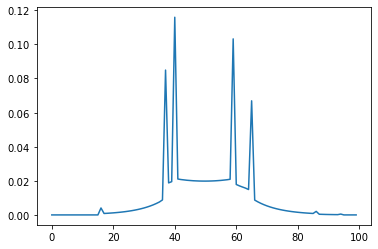

In [8]:
"""print(pd.DataFrame(ramsey.g))
print(pd.DataFrame(ramsey.prob))
print(pd.DataFrame(ramsey.dist))
print(pd.DataFrame(ramsey.kgpr))"""

plt.plot(ramsey.dist) #all the mass is concentrated at 7

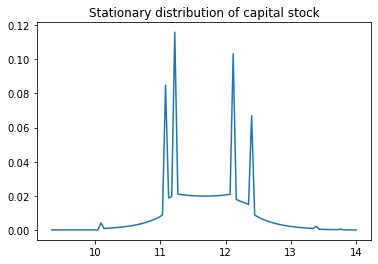

In [9]:
fig, ax = plt.subplots()
ax.set_title("Stationary distribution of capital stock")

    
ax.plot(ramsey.kgrid, ramsey.dist, label="$k'$")
plt.show()

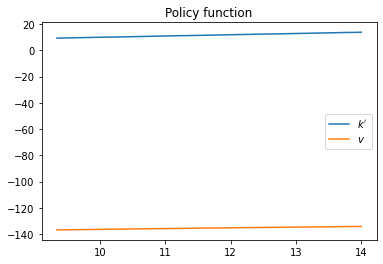

In [10]:
#need these to be 3d
fig, ax = plt.subplots()
ax.set_title("Policy function")

    
ax.plot(ramsey.kgrid, ramsey.gpr[0], label="$k'$")
ax.legend()

ax.plot(ramsey.kgrid, ramsey.v[0], label="$v$")
ax.legend()
plt.show()

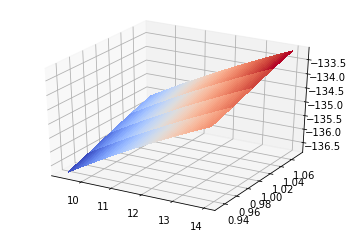

In [11]:
#capital 3-D plot
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xx, yy = ramsey.kgrid, ramsey.zgrid 
X, Y = np.meshgrid(xx, yy)
Z = ramsey.v #v is value and gpr is saving policy

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

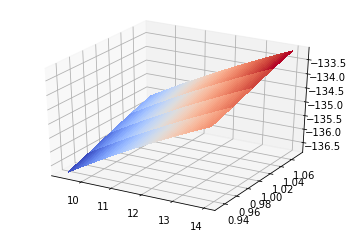

In [12]:
#value 3-D plot
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xx, yy = ramsey.kgrid, ramsey.zgrid 
X, Y = np.meshgrid(xx, yy)
Z = ramsey.v #v is value and gpr is saving policy

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [20]:
#this is from Rajesh
#get mean and std and volatility 
mean_gdp = ramsey.prob @ ramsey.gdp.flatten()
std_gdp = (ramsey.prob @ (ramsey.gdp.flatten()-mean_gdp)**2)**(1/2)
print(f"gdp std: {std_gdp}")
print(f"gdp mean: {mean_gdp}")
print(f"gdp volatility: {np.round(100*std_gdp/mean_gdp,3)}")

mean_cons = ramsey.prob @ ramsey.cons.flatten()
std_cons = (ramsey.prob @ (ramsey.cons.flatten()-mean_cons)**2)**(1/2)
print(f"cons std: {std_cons}")
print(f"cons mean: {mean_cons}")
print(f"cons volatility: {np.round(100*std_cons/mean_cons,3)}")

mean_labor = ramsey.prob @ ramsey.labor.flatten()
std_labor = (ramsey.prob @ (ramsey.labor.flatten()-mean_labor)**2)**(1/2)
print(f"labor std: {std_labor}")
print(f"labor mean: {mean_labor}")
print(f"labor volatility: {np.round(100*std_labor/mean_labor,3)}")

mean_inv = ramsey.prob @ ramsey.inv.flatten()
std_inv = (ramsey.prob @ (ramsey.inv.flatten()-mean_inv)**2)**(1/2)
print(f"inv std: {std_inv}")
print(f"inv mean: {mean_inv}")
print(f"inv volatility: {np.round(100*std_inv/mean_inv,3)}")

mean_capital = ramsey.prob @ ramsey.gpr.flatten()
std_capital = (ramsey.prob @ (ramsey.gpr.flatten()-mean_capital)**2)**(1/2)
print(f"capital std: {std_capital}")
print(f"capital mean: {mean_capital}")
print(f"capital volatility: {np.round(100*std_capital/mean_capital,3)}")

gdp_con_correlation = ramsey.prob @ ((ramsey.gdp.flatten()-mean_gdp)*(ramsey.cons.flatten()-mean_cons))/std_gdp/std_cons
gdp_labor_correlation = ramsey.prob @ ((ramsey.gdp.flatten()-mean_gdp)*(ramsey.labor.flatten()-mean_labor))/std_gdp/std_labor
gdp_inv_correlation = ramsey.prob @ ((ramsey.gdp.flatten()-mean_gdp)*(ramsey.inv.flatten()-mean_inv))/std_gdp/std_inv

print(f"gdp-consumption correlation: {gdp_con_correlation}")
print(f"gdp-labor correlation: {gdp_labor_correlation}")
print(f"gdp-investment correlation: {gdp_inv_correlation}")

gdp std: 0.0568171096692475
gdp mean: 1.1397180418790267
gdp volatility: 4.985
cons std: 0.029800052749165584
cons mean: 0.8471541962799726
cons volatility: 3.518
labor std: 0.005928592102773202
labor mean: 0.30716647378411577
labor volatility: 1.93
inv std: 0.035698256198986374
inv mean: 0.29256384559905413
inv volatility: 12.202
capital std: 0.576912028877287
capital mean: 11.702553810891013
capital volatility: 4.93
gdp-consumption correlation: 0.8392218026451993
gdp-labor correlation: 0.7274967297219576
gdp-investment correlation: 0.8910310773968246


In [24]:
gdp_next = ramsey.g @ ramsey.gdp.flatten()
cons_next = ramsey.g @ ramsey.cons.flatten()
labor_next = ramsey.g @ ramsey.labor.flatten()
inv_next = ramsey.g @ ramsey.inv.flatten()
capital_next = ramsey.g @ ramsey.gpr.flatten()

gdp_autocorrelation = ramsey.prob @ ((ramsey.gdp.flatten()-mean_gdp)*(gdp_next-mean_gdp))/(std_gdp**2)
cons_autocorrelation = ramsey.prob @ ((ramsey.cons.flatten()-mean_cons)*(cons_next-mean_cons))/(std_cons**2)
labor_autocorrelation = ramsey.prob @ ((ramsey.labor.flatten()-mean_labor)*(labor_next-mean_labor))/(std_labor**2)
inv_autocorrelation = ramsey.prob @ ((ramsey.inv.flatten()-mean_inv)*(inv_next-mean_inv))/(std_inv**2)
capital_autocorrelation = ramsey.prob @ ((ramsey.gpr.flatten()-mean_capital)*(capital_next-mean_capital))/(std_capital**2)

print(f"gdp autocorrelation: {gdp_autocorrelation}")
print(f"consumption autocorrelation: {cons_autocorrelation}")
print(f"labor autocorrelation: {labor_autocorrelation}")
print(f"investment autocorrelation: {inv_autocorrelation}")
print(f"capital autocorrelation: {capital_autocorrelation}")

gdp autocorrelation: 0.943604671991992
consumption autocorrelation: 0.9798882147821567
labor autocorrelation: 0.833723434392658
investment autocorrelation: 0.8704345255677598
capital autocorrelation: 0.9983569707917801


In [15]:
"""mean_gdp = ramsey.prob @ ramsey.gdp.flatten()
std_gdp = ramsey.prob @ (ramsey.gdp.flatten()-mean_gdp)**2
vectorized_consumption = ramsey.prob * ramsey.cons.flatten()
vectorized_labor = ramsey.prob * ramsey.labor.flatten()
vectorized_investment = ramsey.prob * ramsey.inv.flatten()
vectorized_capital = ramsey.prob * ramsey.gpr.flatten() #gpr or kgpr?



print(f"cons std: {np.std(vectorized_consumption)}")
print(f"gdp std: {np.std(vectorized_gdp)}")
print(f"labor std: {np.std(vectorized_labor)}")
print(f"inv std: {np.std(vectorized_investment)}")
print(f"capital std: {np.std(vectorized_capital)}")

gdp_volatility = np.std(vectorized_gdp)/np.mean(vectorized_gdp)
consumption_volatility = np.std(vectorized_consumption)/np.mean(vectorized_consumption)
labor_volatility = np.std(vectorized_labor)/np.mean(vectorized_labor)
investment_volatility = np.std(vectorized_investment)/np.mean(vectorized_investment)
capital_volatility = np.std(vectorized_capital)/np.mean(vectorized_capital)

print(f"consumption volatility %: {consumption_volatility}")
print(f"gdp volatility %: {gdp_volatility}")
print(f"labor volatility %: {labor_volatility}")
print(f"investment volatility %: {investment_volatility}")
print(f"capital volatility %: {capital_volatility}")"""

cons std: 0.006380184567660804


NameError: name 'vectorized_gdp' is not defined

In [ ]:
"""gdp_autocorrelation = np.correlate(vectorized_gdp, vectorized_gdp)
consumption_autocorrelation = np.correlate(vectorized_consumption, vectorized_consumption)
labor_autocorrelation = np.correlate(vectorized_labor, vectorized_labor)
investment_autocorrelation = np.correlate(vectorized_investment, vectorized_investment)
capital_autocorrelation = np.correlate(vectorized_capital, vectorized_capital)

gdp_cons_correlation = np.correlate(vectorized_gdp, vectorized_consumption)
gdp_labor_correlation = np.correlate(vectorized_gdp, vectorized_labor)
gdp_inv_correlation = np.correlate(vectorized_gdp, vectorized_investment)
gdp_capital_correlation = np.correlate(vectorized_gdp, vectorized_capital)

print(f"gdp autocorrelation: {gdp_autocorrelation}")
print(f"consumption autocorrelation: {consumption_autocorrelation}")
print(f"labor autocorrelation: {labor_autocorrelation}")
print(f"investment autocorrelation: {investment_autocorrelation}")
print(f"capital autocorrelation: {capital_autocorrelation}")

print(f"gdp-consumption correlation: {gdp_cons_correlation}")
print(f"gdp-labor correlation: {gdp_labor_correlation}")
print(f"gdp-investment correlation: {gdp_inv_correlation}")
print(f"gdp-capital correlation: {gdp_capital_correlation}")"""

In [ ]:
plt.plot(ramsey.zgrid)
plt.show()

np.std(ramsey.zgrid)/np.mean(ramsey.zgrid) #nowhere near rho (0.9)